In [498]:
%matplotlib inline

import numpy as np
import pandas as pd
from scipy import signal, ndimage, interpolate, stats
from scipy.interpolate import CubicSpline

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
font = {'family' : 'sans-serif',
        'size'   : 20}

plt.rc('font', **font)

from pathlib import Path
import os,sys
import h5py
import sys 

from circus.shared.parser import CircusParser
from circus.shared.files import load_data
import time

import nept
sys.path.append('../PreProcessing/')  
from pre_process_neuralynx import *
from shapely.geometry import Point
from shapely.geometry.polygon import LinearRing, Polygon
from collections import Counter
from descartes import PolygonPatch

In [2]:
# path to tracking data
datPath = '/Users/alexgonzalez/Google Drive/PostDoc/Data/T3g/Li/Li_T3g_060418/VT1.nvt'

In [561]:
def medFilt(x,window):
    if window%2:
            window=window-1
    win2 = np.int(window/2)
    N=len(x)
    y=np.array(x)
    for ii in np.arange(win2,N-win2+1):
        try:
            idx=(np.arange(-win2,win2)+ii).astype(np.int)
            y[ii] = np.nanmedian(x[idx])
        except:
            pass
    return y

In [796]:
def AngMedFilt(ang,window):

    xa = np.cos(ang)
    ya = np.sin(ang)
    
    xa=medFilt(xa,window)
    ya=medFilt(ya,window)
    ang2 = np.angle(xa+1j*ya)
    return ang2

In [584]:
def movMeanAngleFilt(ang,window):
    if window%2:
            window=window-1
    win2 = np.int(window/2)
    N=len(ang)
    xa = np.cos(2*np.pi*ang)
    ya = np.sin(2*np.pi*ang)
    xa2 = np.array(xa)
    ya2 = np.array(ya)
    for ii in np.arange(win2,N-win2+1):
        try:
            idx=(np.arange(-win2,win2)+ii).astype(np.int)            
            xa2[ii] = np.nanmean(xa[idx])
            ya2[ii] = np.nanmean(ya[idx])
        except:
            pass
    ang2 = np.angle(xa2+1j*ya2)
    return ang2

In [623]:
def FIR_Ang_filter(ang, b_coeffs):
    xa = np.cos(2*np.pi*ang)
    ya = np.sin(2*np.pi*ang)
    
    xa = signal.filtfilt(b_coeffs,1,xa)
    ya = signal.filtfilt(b_coeffs,1,ya)
    
    ang2 = np.angle(xa+1j*ya)
    return ang2

In [797]:
ha3 = AngMedFilt(ha,15)

In [795]:
ha=np.deg2rad(pos['ha'])
ha2= movMeanAngleFilt(ha,15)
ha3 = AngMedFilt(ha,15)
b = signal.firwin(15, cutoff = 0.2, window = "hanning")
ha4= FIR_Ang_filter(ha2, b)

NameError: name 'xa2' is not defined

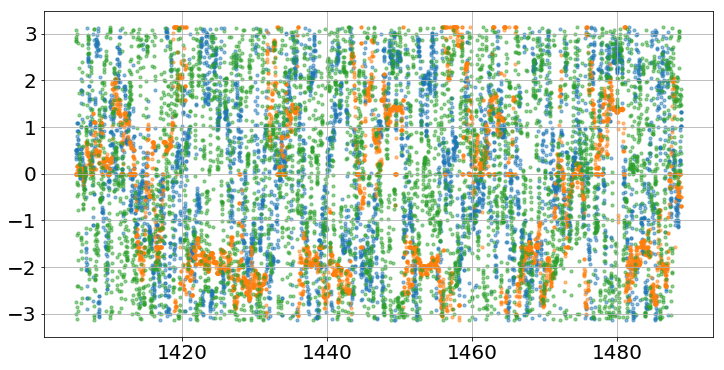

In [799]:
f,a1=plt.subplots(1,1, figsize=(12,6))
a1.grid() 
window = np.arange(5000)+2000*16
#plt.scatter(t[window],ha[window]-np.pi,10,alpha=0.5)

plt.scatter(t[window],ha2[window],10,alpha=0.5)
plt.scatter(t[window],ha3[window],10,alpha=0.5)
plt.scatter(t[window],ha4[window],10,alpha=0.5)

(array([4589., 4531., 4712., 4635., 4625., 4579., 4687., 4742., 4737.,
        4777., 4807., 5072., 5273., 5375., 5812., 6004., 6111., 5738.,
        5545., 5273., 5158., 4864., 4673., 4851., 4834., 4658., 4581.,
        4615., 4660., 4516., 4483.]),
 array([-3.14159265e+00, -2.94524311e+00, -2.74889357e+00, -2.55254403e+00,
        -2.35619449e+00, -2.15984495e+00, -1.96349541e+00, -1.76714587e+00,
        -1.57079633e+00, -1.37444679e+00, -1.17809725e+00, -9.81747704e-01,
        -7.85398163e-01, -5.89048623e-01, -3.92699082e-01, -1.96349541e-01,
         3.55271368e-15,  1.96349541e-01,  3.92699082e-01,  5.89048623e-01,
         7.85398163e-01,  9.81747704e-01,  1.17809725e+00,  1.37444679e+00,
         1.57079633e+00,  1.76714587e+00,  1.96349541e+00,  2.15984495e+00,
         2.35619449e+00,  2.55254403e+00,  2.74889357e+00,  2.94524311e+00]),
 <a list of 31 Patch objects>)

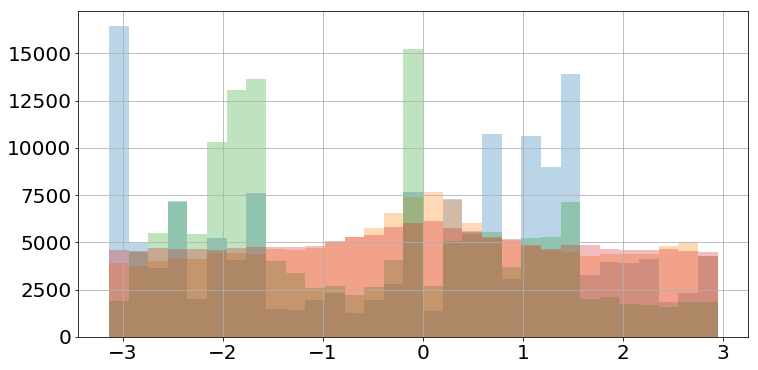

In [800]:
f,a1=plt.subplots(1,1, figsize=(12,6))
a1.grid() 
plt.hist(ha-np.pi,bins=np.arange(-np.pi,np.pi,np.pi/16),alpha=0.3)
plt.hist(ha2,bins=np.arange(-np.pi,np.pi,np.pi/16),alpha=0.3)
plt.hist(ha3,bins=np.arange(-np.pi,np.pi,np.pi/16),alpha=0.3)
plt.hist(ha4,bins=np.arange(-np.pi,np.pi,np.pi/16),alpha=0.3)

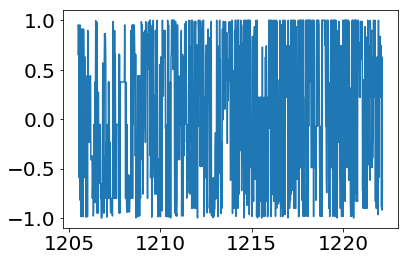

In [571]:
plt.plot(t[window],xa[window])

In [555]:
def loadnvt2(filename):
    f = open(filename, 'rb')

    # Neuralynx files have a 16kbyte header
    header = f.read(2 ** 14).strip(b'\x00')

    # The format for .nvt files according the the neuralynx docs is
    # uint16 - beginning of the record
    # uint16 - ID for the system
    # uint16 - size of videorec in bytes
    # uint64 - timestamp in microseconds
    # uint32 x 400 - points with the color bitfield values
    # int16 - unused
    # int32 - extracted X location of target
    # int32 - extracted Y location of target
    # int32 - calculated head angle in degrees clockwise from the positive Y axis
    # int32 x 50 - colored targets using the same bitfield format used to extract colors earlier
    dt = np.dtype([('filler1', '<h', 3), ('time', '<Q'), ('points', '<i', 400),
                   ('filler2', '<h'), ('x', '<i'), ('y', '<i'), ('head_angle', '<i'),
                   ('targets', '<i', 50)])
    data = np.fromfile(f, dt)

    nvt_data = dict()
    nvt_data['time'] = data['time'] * 1e-6
    nvt_data['x'] = np.array(data['x'], dtype=float)
    nvt_data['y'] = np.array(data['y'], dtype=float)    
    nvt_data['ha'] = np.array(data['head_angle'], dtype=float)
    nvt_data['targets'] = np.array(data['targets'], dtype=float)

    return nvt_data

In [556]:
pos = loadnvt2(datPath)

In [649]:
t = pos['time']
x = pos['x']
y = pos['y']
ha = np.deg2rad(pos['ha'])
        
def ScaleRotateSmoothTrackDat(t,x,y,ha):
    # rotation angle
    rad=0.03 

    # out of bound zones
    mask = y>420 
    mask = np.logical_or(mask,x<200)
    
    xm=np.array(x)
    ym=np.array(y)
    ha_m=np.array(ha)
    xm[mask]=np.nan
    ym[mask]=np.nan
    ha_m[mask]=np.nan
    
    # double round of median filters to deal with NaNs
    x = medFilt(medFilt(xm,11),11)
    y = medFilt(medFilt(ym,11),11)
    ha = movMeanAngleFilt(movMeanAngleFilt(ha,11),11)
    
    # filter / spatial smoothing
    b = signal.firwin(15, cutoff = 0.2, window = "hanning")
    x = signal.filtfilt(b,1,x)
    y = signal.filtfilt(b,1,y)
    ha = FIR_Ang_filter(ha,b)
    
    # move and scale
    x=(y-280)/269*1308
    y=(-x+530)/305*1358

    # finer rotation
    x2 = x*np.cos(rad)+y*np.sin(rad)+5
    y2 = -x*np.sin(rad)+y*np.cos(rad)
    
    return x2,y2,ha,tp

xs,ys,has,tp = ScaleRotateSmoothTrackDat(t,x,y,ha,TimeStep)

In [ ]:
def ReSampleDat(t,sig,step=0.02)
    'Nearest neighborh interpolation for resampling.'
    
    tp=np.arange(t[0],t[-1],step)
    sig_ip = interpolate.interp1d(t, sig, kind="nearest",fill_value="extrapolate")

    return sig_ip(tp)

In [782]:
spz,thz = velocity(x,y)

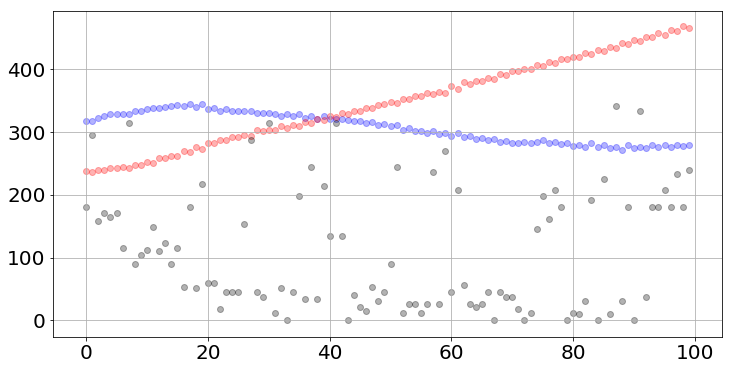

In [843]:
f,a1=plt.subplots(1,1, figsize=(12,6))
a1.grid()
t = pos['time']
x = pos['x']
y = pos['y']
ha = np.deg2rad(pos['ha'])
xa = np.cos(ha)
ya = np.sin(ha)
window = np.arange(100)+500*21+50
plt.scatter(np.arange(len(window)),y[window],alpha=0.3,color='b')
plt.scatter(np.arange(len(window)),x[window],alpha=0.3,color='r')
plt.scatter(np.arange(len(window)),np.rad2deg(ha[window]),alpha=0.3,color='k')

In [806]:


P=pd.DataFrame([np.rad2deg(thz[window]),np.rad2deg(ha[window])])
P


,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,172.925339,169.706025,167.610683,166.407961,165.774567,165.395447,165.057697,164.688321,164.315772,164.160326,...,176.752564,176.222071,176.176233,176.627678,177.422761,178.030006,177.881441,177.308431,176.863286,176.55559
1,259.000000,244.000000,240.000000,190.000000,199.000000,296.000000,90.000000,180.000000,180.000000,303.000000,...,270.000000,281.000000,284.000000,270.000000,249.000000,270.000000,259.000000,284.000000,270.000000,281.00000


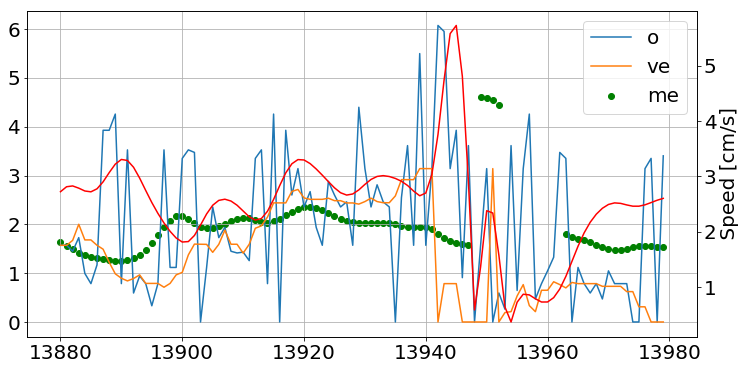

In [900]:
f,a1=plt.subplots(1,1, figsize=(12,6))
a1.grid()
#window = np.arange(200)+500*23+123
window = np.arange(100)+500*27+380
thzz = thz[window]-np.pi/2+np.pi
spzz = spz[window]
a1.plot(window,ha[window])
a1.scatter(window[spzz>1],thzz[spzz>1],color='g')
a1.plot(window,ha3[window])

a2 = a1.twinx()
a2.plot(window,spz[window],color='r')
a2.set_ylabel(' Speed [cm/s] ')
a1.legend(['o','ve','me'])

In [856]:
?np.unwrap

array([0.4712389 , 3.40339204, 0.33161256, 0.4712389 , 6.0737458 ,
       0.33161256, 0.15707963, 0.        , 0.26179939, 0.20943951,
       5.95157275, 6.10865238, 6.0737458 , 5.6025069 , 5.89921287,
       5.95157275, 5.63741348, 5.34070751, 5.32325422, 5.11381471,
       4.46804289, 4.36332313, 5.02654825, 4.52040276, 4.25860337,
       4.1887902 , 3.31612558, 3.47320521, 5.16617459, 1.57079633,
       3.14159265, 3.14159265, 5.28834763, 3.47320521, 4.1887902 ,
       3.68264472, 4.46804289, 4.13643033, 3.14159265, 2.93215314,
       3.14159265, 3.35103216, 0.        , 4.39822972, 5.02654825,
       4.95673508, 4.71238898, 4.52040276, 4.46804289, 4.71238898,
       4.9043752 , 4.95673508, 4.71238898, 4.34586984, 4.71238898,
       4.52040276, 4.95673508, 4.71238898, 4.9043752 , 4.86946861,
       4.88692191, 4.71238898, 4.79965544, 0.        , 3.7350046 ,
       3.78736448, 4.25860337, 4.34586984, 4.25860337, 4.39822972,
       4.45058959, 4.25860337, 4.45058959, 4.55530935, 4.71238

(array([3571., 3703., 3667., 3592., 3855., 3781., 3875., 3975., 4025.,
        4042., 4155., 4365., 4505., 4747., 4794., 5012., 4988., 4913.,
        4867., 4544., 4357., 4082., 4043., 4140., 3941., 3945., 3737.,
        3654., 3760., 3827., 3729.]),
 array([-3.14159265e+00, -2.94524311e+00, -2.74889357e+00, -2.55254403e+00,
        -2.35619449e+00, -2.15984495e+00, -1.96349541e+00, -1.76714587e+00,
        -1.57079633e+00, -1.37444679e+00, -1.17809725e+00, -9.81747704e-01,
        -7.85398163e-01, -5.89048623e-01, -3.92699082e-01, -1.96349541e-01,
         3.55271368e-15,  1.96349541e-01,  3.92699082e-01,  5.89048623e-01,
         7.85398163e-01,  9.81747704e-01,  1.17809725e+00,  1.37444679e+00,
         1.57079633e+00,  1.76714587e+00,  1.96349541e+00,  2.15984495e+00,
         2.35619449e+00,  2.55254403e+00,  2.74889357e+00,  2.94524311e+00]),
 <a list of 31 Patch objects>)

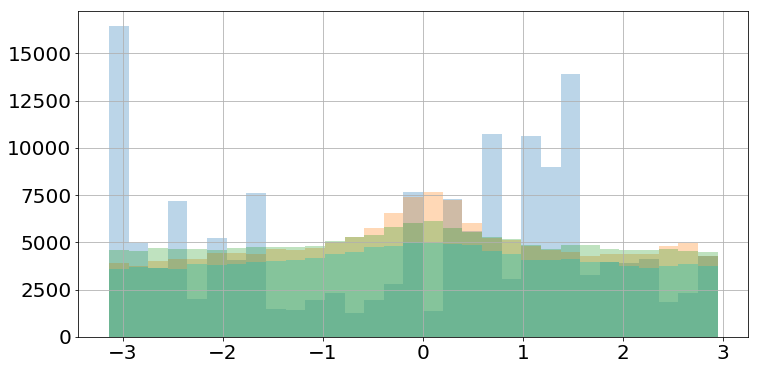

In [654]:
f,a1=plt.subplots(1,1, figsize=(12,6))
a1.grid() 
plt.hist(ha-np.pi,bins=np.arange(-np.pi,np.pi,np.pi/16),alpha=0.3)
plt.hist(ha2,bins=np.arange(-np.pi,np.pi,np.pi/16),alpha=0.3)
plt.hist(ha4,bins=np.arange(-np.pi,np.pi,np.pi/16),alpha=0.3)
plt.hist(has,bins=np.arange(-np.pi,np.pi,np.pi/16),alpha=0.3,color='c')

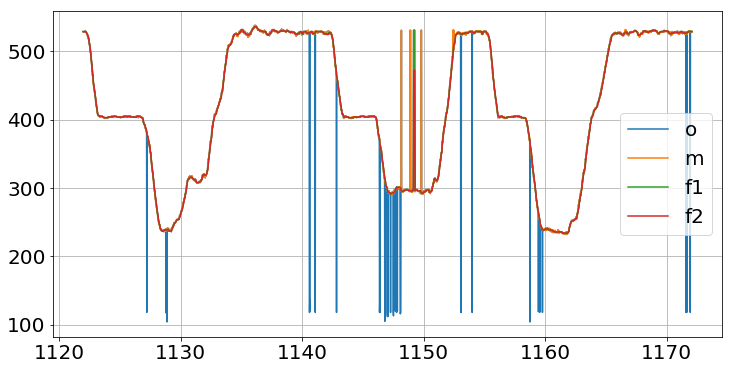

In [449]:
f,a1=plt.subplots(1,1, figsize=(12,6))
a1.grid() 
window = np.arange(3000)+3000*5

a1.plot(t[window],x[window])
a1.plot(t[window],xm[window])
a1.plot(t[window],x_m1[window])
a1.plot(t[window],x_m2[window])
#a1.plot(tp[window],-ys[window])
a1.legend(['o','m','f1','f2'])

In [252]:
print(np.sum(np.isnan(x_m)),np.sum(np.isnan(xm)))

0 4505


4656
0


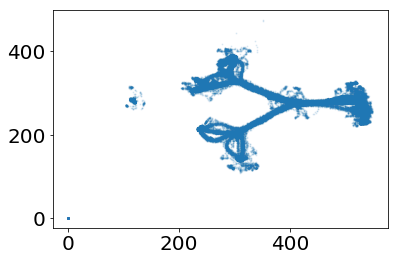

In [697]:
plt.scatter(x,y,1,alpha=0.1)
mask = y>420
mask = np.logical_or(mask,x<200)
print(np.sum(mask))
print(np.sum(np.isnan(xs)))

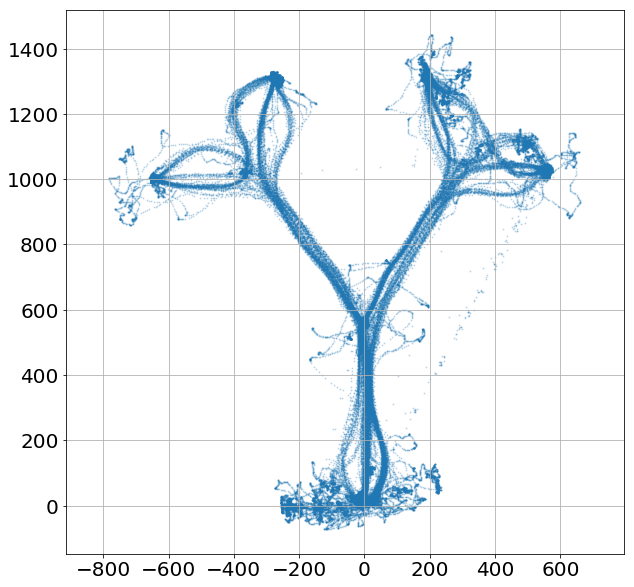

In [300]:
# plot and get a sense of the tilt
f,a1=plt.subplots(1,1, figsize=(10,10))

a1.scatter(xs,ys,1,alpha=0.2)
a1.axis('equal')
a1.grid()

In [168]:
def getPoly(coords):
    return Polygon(coords)
def plotPoly(poly,ax,alpha=0.3):    
    p1x,p1y = poly.exterior.xy
    ax.plot(p1x, p1y, color='k', alpha=alpha,
        linewidth=3,)
    ring_patch = PolygonPatch(poly, fc='b', ec='none', alpha=alpha)
    ax.add_patch(ring_patch)
    #ax.fill(p1x, p1x, alpha=1, fc='r', ec='none')

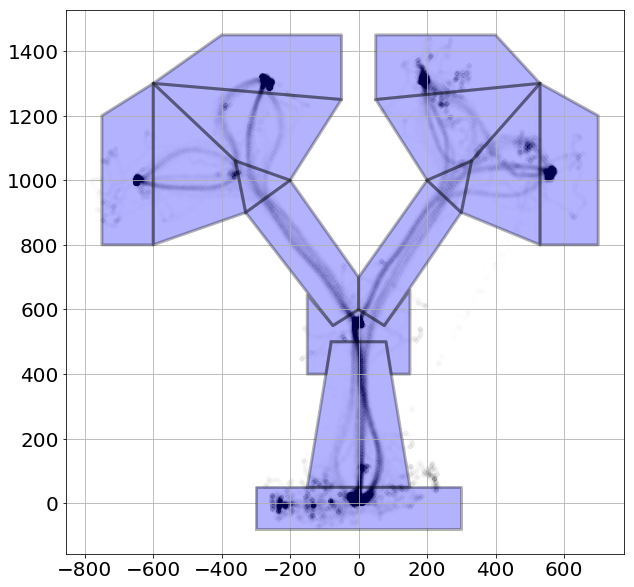

In [297]:
MazeZonesCoords ={'Home':[(-300, -80), (-300, 50),(300,50),(300, -80)],
                  'Center': [(-80,500),(-95,400),(-150,400),(-150,645),
                             (-75,550),(0,600),(75,550),(150,660),(150,400),(95,400),(80,500)],
                  'SegA': [(-150,50),(-80,500),(80,500),(150,50)],
                  'SegB': [(0,600),(0,700),(200,1000),(300,900),(75, 550)],
                  'SegC': [(330,1060),(530,1300),(530,800),(300,900)],
                  'SegD': [(200,1000),(50,1250),(530,1300),(330,1060)],
                  'SegE': [(0,600),(0,700),(-200,1000),(-330,900),(-75, 550)],
                  'SegF': [(-200,1000),(-50,1250),(-600,1300),(-360,1060)],
                  'SegG': [(-360,1060),(-600,1300),(-600,800),(-330,900)],
                  
                  'G1': [(530,1300),(700,1200),(700,800),(530,800)],
                  'G2': [(50,1250),(50,1450),(400,1450),(530,1300)],
                  'G3': [(-50,1250),(-50,1450),(-400,1450),(-600,1300)],
                  'G4': [(-600,1300),(-750,1200),(-750,800),(-600,800)],
                  
                  'I1': [(200,1000),(330,1060),(300,900)],
                  'I2': [(-330,900),(-360,1060),(-200,1000)],
                 }
MazeZonesGeom = {}
for zo in MazeZonesCoords.keys():
   MazeZonesGeom[zo] = getPoly(MazeZonesCoords[zo])

f,a1=plt.subplots(1,1, figsize=(10,10))
a1.scatter(xs,ys,20,alpha=0.003,color='k')
a1.grid() 

for zo in MazeZonesGeom.keys():
    plotPoly(MazeZonesGeom[zo],a1)

In [285]:
ZoneOrd=['Home','SegA','Center','SegB','I1','SegC','G1','SegD','G2','SegE','I2','SegF','G3', 'SegG','G4']
Zones = {}
cnt=0
for z in ZoneOrd:
    Zones[z]=ZoneOrd[cnt]
    cnt+=1

nZones = len(ZoneOrd)
PosZones = np.zeros(len(xs),dtype=int)
pcnt = -1

for xp, yp in zip(xs,ys):
    pcnt+=1
    zcnt=0
    outZoneFlag = 0
    if not np.isnan(xp):
        pZoneDist = np.zeros(nZones)
        p = Point(xp,yp)
        for zo in ZoneOrd:
            pZoneDist[zcnt]=MazeZonesGeom[zo].distance(p)
            if MazeZonesGeom[zo].contains(p):
                PosZones[pcnt]=zcnt
                break
            elif zo == ZoneOrd[-1]:
                if np.min(pZoneDist)<20:
                    PosZones[pcnt]=np.argmin(pZoneDist)                   
                else:
                    PosZones[pcnt]=PosZones[pcnt-1]
                break
            zcnt+=1
    else:
        PosZones[pcnt]=PosZones[pcnt-1]
    
#negIdx = 
        
        

In [286]:
def transition_matrix(transitions):
    n = 1+ max(transitions) #number of states

    M = [[0]*n for _ in range(n)]

    for (i,j) in zip(transitions,transitions[1:]):
        M[i][j] += 1

    #now convert to probabilities:
#     for row in M:
#         s = sum(row)
#         if s > 0:
#             row[:] = [f/s for f in row]
    return M

In [287]:
M = pd.DataFrame(transition_matrix(PosZones),columns=ZoneOrd,index=ZoneOrd)
M

,Home,SegA,Center,SegB,I1,SegC,G1,SegD,G2,SegE,I2,SegF,G3,SegG,G4
Home,38341,175,0,0,0,0,0,0,0,0,0,0,0,0,0
SegA,176,13845,152,0,0,8,0,0,0,0,0,0,0,0,0
Center,0,152,18631,77,0,0,0,0,0,73,0,0,0,0,0
SegB,0,0,79,5106,75,0,0,0,0,4,0,0,0,0,0
I1,0,0,0,75,1283,36,0,61,0,0,0,0,0,0,0
SegC,0,8,0,0,57,4867,69,16,0,0,0,0,0,0,0
G1,0,0,0,0,0,69,6020,0,0,0,0,0,0,0,0
SegD,0,0,0,0,40,36,0,4542,66,0,1,0,0,0,0
G2,0,0,0,0,0,0,0,66,10083,0,0,0,0,0,0
SegE,0,0,71,6,0,0,0,0,0,4738,74,0,0,0,0


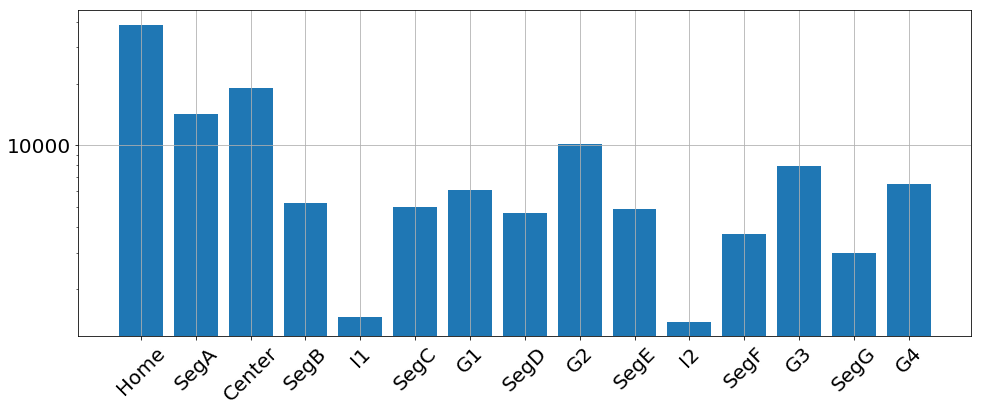

In [288]:
f,a1=plt.subplots(1,1, figsize=(16,6))
a=Counter(PosZones)
counts,_ = np.histogram(PosZones,np.arange(nZones+1))
zoneIDs = np.arange(nZones)
a1.bar(np.arange(nZones), counts)
a1.set_yscale('log')
#a1.set_yticks([100,200, 500, 1000])
a1.set_xticks(np.arange(len(ZoneOrd)))
a1.set_xticklabels(ZoneOrd)
a1.get_yaxis().set_major_formatter(ticker.ScalarFormatter())
a1.grid()

for tick in a1.get_xticklabels():
    tick.set_rotation(45)


In [213]:
counts, ids=np.histogram(PosZones,nZones+2)
print(len(counts),counts)
print(len(ids[0:nZones]),ids[0:nZones],nZones)


17 [40467 13879 20753  5379  1644     0  3835  5138  5676  8811  5150     0
  1991  3846  6759  2432  6026]
15 [ 0.          0.82352941  1.64705882  2.47058824  3.29411765  4.11764706
  4.94117647  5.76470588  6.58823529  7.41176471  8.23529412  9.05882353
  9.88235294 10.70588235 11.52941176] 15


array([40467, 13879, 20753,  5379,  1644,  3835,  5138,  5676,  8811,
        5150,  1991,  3846,  6759,  2432,  6026,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0])

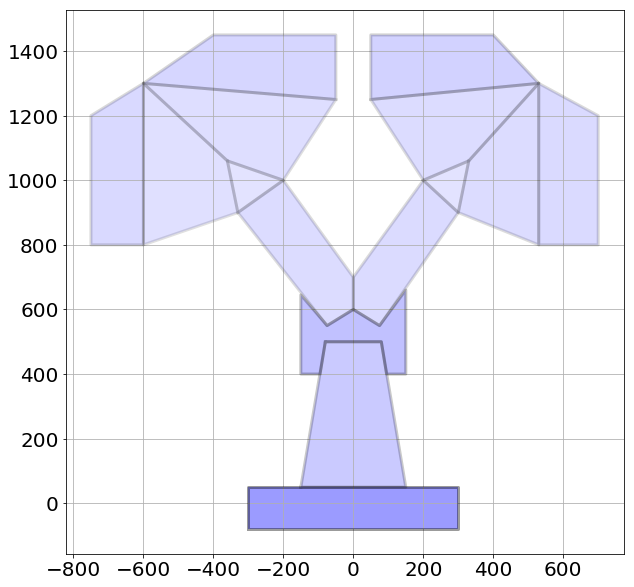

In [302]:
prob = counts/np.sum(counts)
cnt = 0
f,a1=plt.subplots(1,1, figsize=(10,10))
a1.grid() 

for zo in ZoneOrd:
    plotPoly(MazeZonesGeom[zo],a1,alpha=prob[cnt])
    cnt+=1

In [171]:
prob = values/np.sum(values)
values

[13879,
 20753,
 5150,
 1991,
 3846,
 6759,
 2432,
 6026,
 40467,
 5379,
 5138,
 3835,
 5676,
 8811,
 1644]

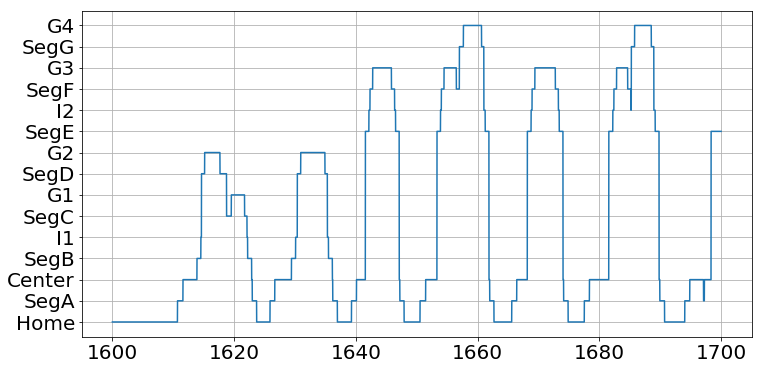

In [450]:
ZoneOrd=['Home','SegA','Center','SegB','I1','SegC','G1','SegD','G2','SegE','I2','SegF','G3', 'SegG','G4']

f,a1=plt.subplots(1,1, figsize=(12,6))
window = np.arange(5000)+5000*16
a1.plot(tp[window]-tp[0],PosZones[window])
a1.set_yticks(np.arange(len(ZoneOrd)))
a1.set_yticklabels(ZoneOrd)
a1.grid()

In [422]:
def atan2v(x,y):
    N = len(y)
    out = np.zeros(N)
    for i in np.arange(N):
        out[i] = np.math.atan2(y[i],x[i])
    return out

def velocity(x,y):
    dx = np.diff(x)
    dy = np.diff(y)
    b = signal.firwin(15, cutoff = 0.2, window = "hanning")
    dx = signal.filtfilt(b,1,dx)
    dy = signal.filtfilt(b,1,dy)
    mag = euclidian(dx,dy)
    ang = atan2v(dx,dy)
    return mag , ang

def euclidian(x,y):
     return np.sqrt(x*x+y*y)
     

In [491]:
sp,th = velocity(-xs,-ys)
th = np.append(0,th+np.pi) # rotate angles such that 0 is at E
sp = np.append(0,sp/TimeStep/10) # convert to cm/s

Text(0,0.5,' Speed [cm/s] ')

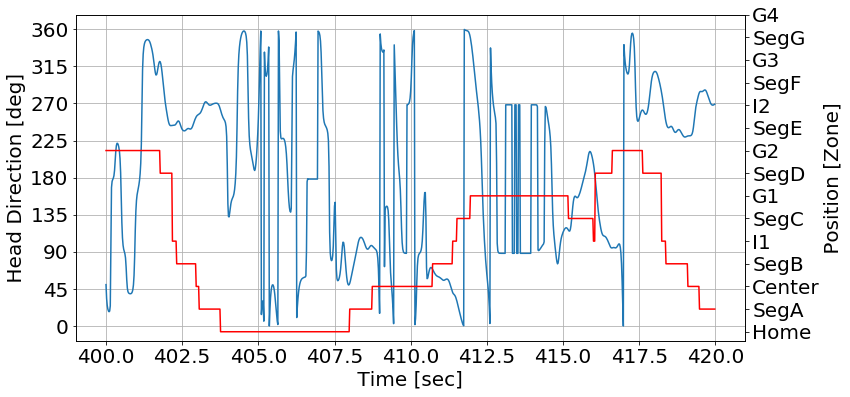

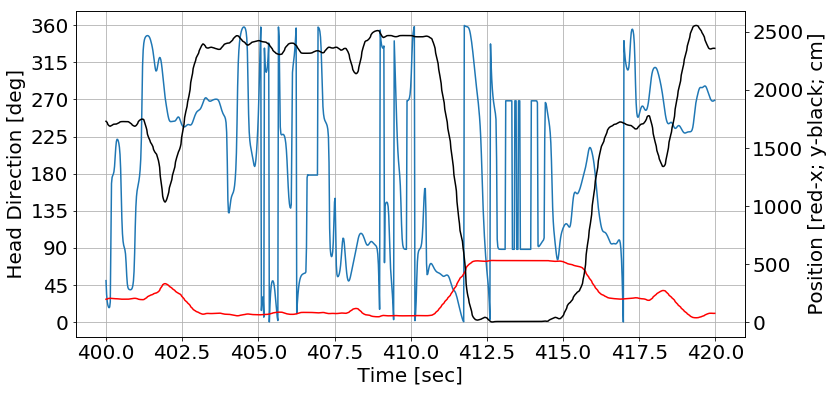

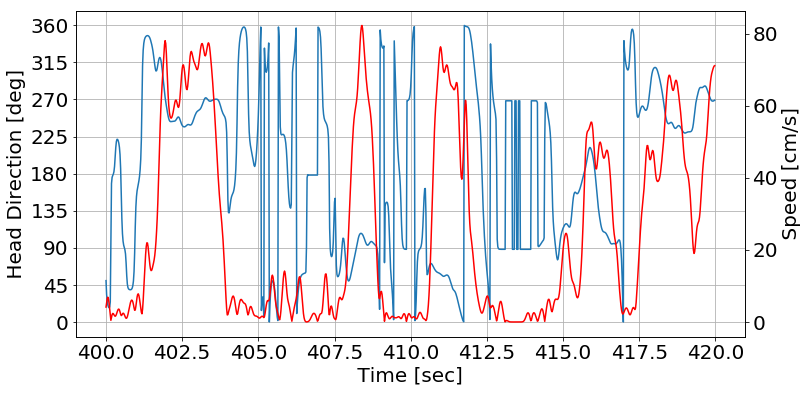

In [655]:
f,a1=plt.subplots(1,1, figsize=(12,6))
window = np.arange(1000)+1000*20
a1.plot(tp[window]-tp[0],np.rad2deg(th[window]))
a1.set_yticks(np.arange(0,370,45))
a1.set_ylabel(' Head Direction [deg] ')
a1.set_xlabel(' Time [sec] ')
a1.grid()

a2 = a1.twinx()
a2.plot(tp[window]-tp[0],PosZones[window],color='r')
a2.set_yticks(np.arange(len(ZoneOrd)))
a2.set_yticklabels(ZoneOrd)
a2.set_ylabel(' Position [Zone] ')

f,a1=plt.subplots(1,1, figsize=(12,6))
window = np.arange(1000)+1000*20
a1.plot(tp[window]-tp[0],np.rad2deg(th[window]))
a1.set_yticks(np.arange(0,370,45))
a1.set_ylabel(' Head Direction [deg] ')
a1.set_xlabel(' Time [sec] ')
a1.grid()

a2 = a1.twinx()
a2.plot(tp[window]-tp[0],xs[window],color='r')
a2.plot(tp[window]-tp[0],ys[window],color='k')
a2.set_ylabel(' Position [red-x; y-black; cm] ')

f,a1=plt.subplots(1,1, figsize=(12,6))
window = np.arange(1000)+1000*20
a1.plot(tp[window]-tp[0],np.rad2deg(th[window]))
a1.set_yticks(np.arange(0,370,45))
a1.set_ylabel(' Head Direction [deg] ')
a1.set_xlabel(' Time [sec] ')
a1.grid()

a2 = a1.twinx()
a2.plot(tp[window]-tp[0],sp[window],color='r')
a2.set_ylabel(' Speed [cm/s] ')


Text(0,0.5,' Position [Zone] ')

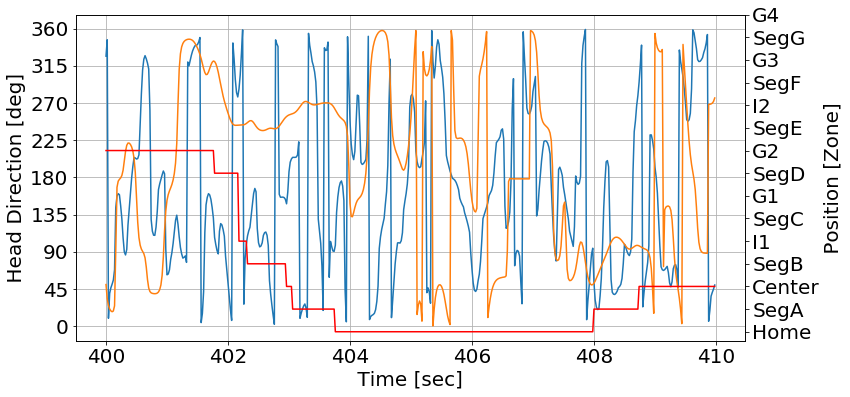

In [660]:
f,a1=plt.subplots(1,1, figsize=(12,6))
window = np.arange(500)+1000*20
a1.plot(tp[window]-tp[0],np.rad2deg(has[window])+180)
a1.plot(tp[window]-tp[0],np.rad2deg(th[window]))
a1.set_yticks(np.arange(0,370,45))
a1.set_ylabel(' Head Direction [deg] ')
a1.set_xlabel(' Time [sec] ')
a1.grid()

a2 = a1.twinx()
a2.plot(tp[window]-tp[0],PosZones[window],color='r')
a2.set_yticks(np.arange(len(ZoneOrd)))
a2.set_yticklabels(ZoneOrd)
a2.set_ylabel(' Position [Zone] ')

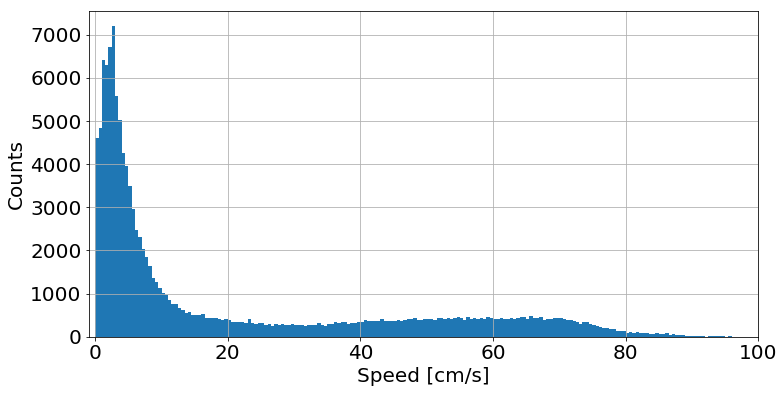

In [494]:
f,a1=plt.subplots(1,1, figsize=(12,6))

a1.hist(sp,np.arange(0,100,0.5))
a1.set_xlim([-1,100])
a1.set_xlabel('Speed [cm/s]')
a1.set_ylabel('Counts')
a1.grid()

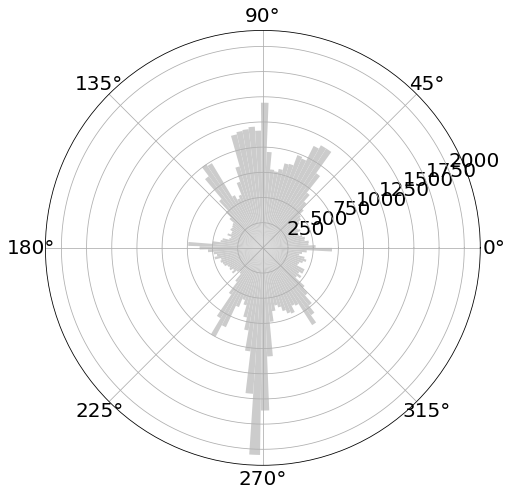

In [524]:
bin_size = 120
a , b=np.histogram(th[sp>5], bins=np.linspace(0, 2*np.pi, bin_size))
cent = b[:-1]+np.diff(b)/2

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='polar')
ax.bar(cent, a, width=2*np.pi/bin_size, bottom=0.0, color='.8', edgecolor=None)
ax.set_theta_zero_location("E")
plt.show()


In [364]:
bin_size = 36
a , b=np.histogram(th, bins=np.linspace(-np.pi, np.pi, bin_size))
cent = b[:-1]+np.diff(b)/2

Text(0,0.5,'Heading Direction')

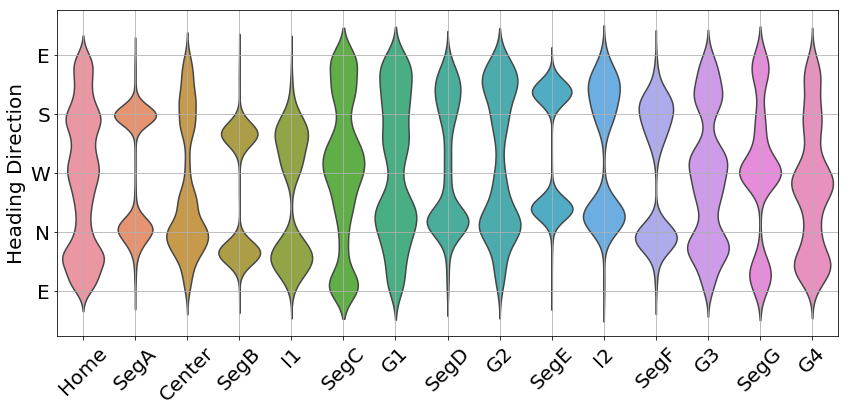

In [518]:
f,a1=plt.subplots(1,1, figsize=(14,6))
thr = sp>5
sns.violinplot(PosZones[thr],th[thr],ax=a1,inner=None,scale='width')
a1.set_xticklabels(ZoneOrd)
a1.grid()
a1.set_yticks([0,np.pi/2,np.pi,np.pi/2*3,2*np.pi])
a1.set_yticklabels(['E','N','W','S','E'])
for tick in a1.get_xticklabels():
    tick.set_rotation(45)
a1.set_ylabel('Heading Direction')

Text(0,0.5,'Speed [cm/s]')

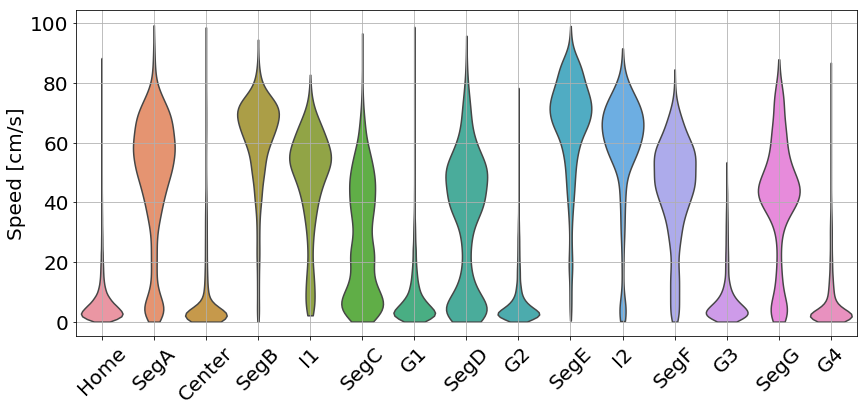

In [538]:
f,a1=plt.subplots(1,1, figsize=(14,6))

thr = sp<100
sns.violinplot(PosZones[thr],sp[thr],ax=a1,inner=None,scale='width',cut=0)
a1.set_xticklabels(ZoneOrd)
a1.grid()
#a1.set_yticks([0,np.pi/2,np.pi,np.pi/2*3,2*np.pi])
#a1.set_yticklabels(['E','N','W','S','E'])
for tick in a1.get_xticklabels():
    tick.set_rotation(45)
a1.set_ylabel('Speed [cm/s]')